<a href="https://colab.research.google.com/github/nrrb/how-to-scrape/blob/main/My_Web_Scraping_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

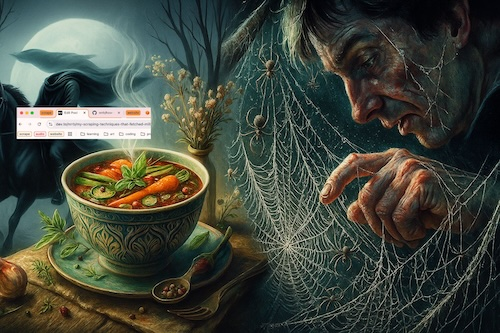

# Web Scraping Unwrapped: From Python Beginner to Data Harvester

> **Ways to Use This Guide:**
>
> 1. Read along. Reading Time: ~25 minutes
> 2. Execute the code in the [Google Colab interactive notebook](https://colab.research.google.com/drive/1qO3GrOUN6GzFYEgQxQPrn8cFs8h5gfRr?usp=sharing). You can see the entire article there and run most of the code. You can create a free account with a Google account.
> 3. Clone the [Github repository](https://github.com/nrrb/how-to-scrape) and run it on your own computer.

## Introduction

Since my post about [Uber scraping](https://dev.to/nrrb/how-i-hacked-ubers-hidden-api-to-download-4379-rides-35ai) has gotten an unexpected windfall of attention, I wanted to share what I know about web scraping for a general audience. Whether you're just getting started with Python and want to try this out, or you've heard about web scraping and are curious about what's involved, read on.

Web scraping is a set of programmatic techniques used to extract structured data from the unstructured data of the web. Structured as in it's in a form **I** want to use, like:

 ```json
{'title': 'Google', 'url': 'https://www.google.com', 'font_family': 'Roboto, Arial, sans-serif'}
```

Not unstructured like:

```html
<html><head><title>Google</title>...</body></html>
```

This article is by no means a canonical description of web scraping, it's just what I know of it. I know that, as a beginner, receiving a deluge of information can be overwhelming for me and I then face a [paradox of choice](https://en.wikipedia.org/wiki/The_Paradox_of_Choice).

If you're a beginner, I suggest that it's more helpful to start with someone else's journey and work from there.

At the end I'll supply some resources that can help you keep going on your own.

# Table of Contents

- [Introduction](#introduction)
- [My Background](#my-background)
- [How I Scrape](#how-i-scrape)
  - [Python: requests](#python-requests)
    - [Python: requests + json/csv/pandas](#python-requests--jsoncsvpandas)
    - [Python: requests + Beautiful Soup](#python-requests--beautiful-soup)
  - [Python with a Headless Browser: Selenium](#python-with-a-headless-browser-selenium)
- [Anti-Scraping Technology](#anti-scraping-technology)
  - [IP Address](#ip-address)
  - [User Agent Filtering / HTTP Headers](#user-agent-filtering--http-headers)
  - [CAPTCHAs / CloudFlare](#captchas--cloudflare)
  - [Honeypots](#honeypots)
  - [Behavior Analysis](#behavior-analysis)
- [The Ethics of Web Scraping](#the-ethics-of-web-scraping)
  - [Terms of Service: The Digital Fine Print](#terms-of-service-the-digital-fine-print)
  - [Rate Limiting: Don't Be a Resource Hog](#rate-limiting-dont-be-a-resource-hog)
  - [The Data Privacy Angle](#the-data-privacy-angle)
  - [Robots.txt: The Digital "No Trespassing" Sign](#robotstxt-the-digital-no-trespassing-sign)
  - [The "Be Reasonable" Test](#the-be-reasonable-test)
  - [Giving Back to the Community](#giving-back-to-the-community)
- [Resources](#resources)
- [Conclusion](#conclusion)

## My Background

I first learned about web scraping in 2009, when I saw some data on a web site that I wanted in a different format. I didn't like their UI and I had an idea in mind for a better interface for me.

Specifically, it was movie data from [IMDB](https://www.imdb.com), and I wanted to visualize connections between cast and movie titles. Based on actors that I liked I wanted to get recommendations on other movies I'd probably like too.

I was art coding at the time in [Processing](https://processing.org/) (a subset of Java). I was making replicas of visual effects from the [demoscene](https://en.wikipedia.org/wiki/Demoscene). I'd previously used C, x86 assembler, and Pascal/Basic/C#, but none of them gave me the ease of use for web scraping that I wanted.

The best candidates for web scraping at the time were Ruby and Python, and I decided to learn Python because my best friend knew it and I'd have a friendly person to ask questions.

> **_KEY_** for learning a new language: find a kind mentor

My pursuit of learning web scraping took me to work in a research lab focused on Social Network Analysis where I [co-authored two published research papers](https://scholar.google.com/citations?hl=en&user=gD1PTGoAAAAJ). This led me on a road of learning Python where I eventually became a Python Developer at a hosting company, and subsequently have used it in every position since. I still web scrape for my personal projects.

## How I Scrape

This is how I scrape, from easiest to hardest.

### Python: requests

If the information I'm trying to get is available as a GET/POST HTTP request, or if it's in a web page that's not generated by JavaScript, I can use a plain HTTP request using the [requests](https://pypi.org/project/requests/) library.

There are other ways to do this, including using the standard library that comes with the Python distribution, but the requests library for Python is built to be simple.

I prefer simple.

This Python code will get me the basic content of `https://www.google.com`:

```python
import requests

url = "https://www.google.com/"
r = requests.get(url)  # This is where we actually make the HTTP request to fetch the URL
if r.status_code==200:  # HTTP 200 means our request was successful
  html = r.content  # The raw HTML content of the page is stored in r.content
  print(f"Retrieved {url}")  # Just confirming we got the page successfully
else:
  # If we didn't get a 200, something went wrong - maybe the site is down or blocked us
  print(f"Couldn't get {url}, HTTP status code was {r.status_code}")
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests

url = "https://www.google.com/"
r = requests.get(url)  # This is where we actually make the HTTP request to fetch the URL
if r.status_code==200:  # HTTP 200 means our request was successful
  html = r.content  # The raw HTML content of the page is stored in r.content
  print(f"Retrieved {url}")  # Just confirming we got the page successfully
else:
  # If we didn't get a 200, something went wrong - maybe the site is down or blocked us
  print(f"Couldn't get {url}, HTTP status code was {r.status_code}")

If you're confused about HTTP codes, they're numbers that a web server sends back to indicate what it thought about the request. [Here's a complete index of different codes the web server might send back, and what they mean.](https://javascript.plainenglish.io/all-the-http-response-status-codes-you-will-ever-need-as-a-web-developer-fee26d3706b4)

Even if you can get away with using using `requests` to get the URL, you're going to need to do some parsing of what you get back.

#### Python: requests + json/csv/pandas

If there's a way to get the data I want from an API rather than the web page itself, and the API returns CSV or JSON (usually), then I can use the built-in [json](https://docs.python.org/3/library/json.html) or [csv](https://docs.python.org/3/library/csv.html) libraries to process the results. If I want to be fancy and do some data processing afterwarsd, I might use [pandas](https://pandas.pydata.org/).

Here's an example of where I could use `csv`. Let's say I wanted to know what the low temperature was in Chicago on January 1, 2025. I can use the [NOAA NCEI Global Surface Summary of the Day API](https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day) to find the URL for the weather station at O'Hare Airport and data from 2025, then request the measurements as CSV and parse them to get my answer:

```python
import requests
import csv

# This URL points to weather data for Chicago's O'Hare Airport for 2025
# NOAA provides this data in a nicely structured CSV format - perfect for scraping!
url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2025/72530094846.csv'

r = requests.get(url)  # Make the HTTP request for the CSV data
if r.status_code==200:  # Check if we got a successful response
  content = r.content.decode('utf-8')  # Convert the raw bytes to a UTF-8 string
  csv_reader = csv.DictReader(content.splitlines())  # Parse the CSV text into a dict reader
  data = list(csv_reader)  # Convert the reader to a list of dictionaries, one per row
  first_day = data[0]  # Grab just the first day's data (Jan 1, 2025)
  # Print the results in a nice readable format
  print(f"The low temperature on {first_day['DATE']} was {first_day['MIN']} F at {first_day['NAME']}.")
# The low temperature on 2025-01-01 was   27.0 F at CHICAGO OHARE INTERNATIONAL AIRPORT, IL US.
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests
import csv

# This URL points to weather data for Chicago's O'Hare Airport for 2025
# NOAA provides this data in a nicely structured CSV format - perfect for scraping!
url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2025/72530094846.csv'

r = requests.get(url)  # Make the HTTP request for the CSV data
if r.status_code==200:  # Check if we got a successful response
  content = r.content.decode('utf-8')  # Convert the raw bytes to a UTF-8 string
  csv_reader = csv.DictReader(content.splitlines())  # Parse the CSV text into a dict reader
  data = list(csv_reader)  # Convert the reader to a list of dictionaries, one per row
  first_day = data[0]  # Grab just the first day's data (Jan 1, 2025)
  # Print the results in a nice readable format
  print(f"The low temperature on {first_day['DATE']} was {first_day['MIN']} F at {first_day['NAME']}.")
# The low temperature on 2025-01-01 was   27.0 F at CHICAGO OHARE INTERNATIONAL AIRPORT, IL US.

Here's an example of where I could use `json`. Let's say I want to use the [Open Library APIs](https://openlibrary.org/developers/api) to get the bibliography of [Thich Nhat Hanh](https://plumvillage.org/about/thich-nhat-hanh), a prolific Buddhist monk whose writings have been immensely influential in my life. You can query their [Authors API](https://openlibrary.org/dev/docs/api/authors) to search by name, then use the unique identifier for a particular author to get their list of works.

One convenience here is that because data is often returned as JSON from an API, you don't need to separately import `json` to decode JSON data. You can use the `.json()` method on the requests object after it returns.

```python
import requests

# This URL searches for authors with the name "thich nhat hanh" in the Open Library API
search_url = 'https://openlibrary.org/search/authors.json?q=thich%20nhat%20hanh'
r = requests.get(search_url)  # Make the HTTP request to the API
if r.status_code==200:  # If the request was successful
  results = r.json()  # Parse the JSON response directly into a Python dictionary
  for result in results['docs']:  # Loop through each author result
    # Print a neatly formatted summary of each author and their work count
    print(f"Key: {result['key']} Author: {result['name']} ({result['work_count']} works on record)")

# Now we'll use the first result (which has the most works) to find their books
author_record = results['docs'][0]  # Grab the first author record (most works)
# Construct a new URL to get up to 1000 works by this author
works_url = f"https://openlibrary.org/authors/{author_record['key']}/works.json?limit=1000"
r = requests.get(works_url)  # Make another HTTP request for the works
if r.status_code==200:  # If this request was also successful
  results = r.json()  # Parse this JSON response
  works = results['entries']  # Get the list of works
  print(f"Found {len(works)} works for {author_record['name']}.")
  print("Here are the first 10 titles:")
  # Loop through the first 10 works and print their titles
  for work in works[:10]:
    print(work['title'])
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests

# This URL searches for authors with the name "thich nhat hanh" in the Open Library API
search_url = 'https://openlibrary.org/search/authors.json?q=thich%20nhat%20hanh'
r = requests.get(search_url)  # Make the HTTP request to the API
if r.status_code==200:  # If the request was successful
  results = r.json()  # Parse the JSON response directly into a Python dictionary
  for result in results['docs']:  # Loop through each author result
    # Print a neatly formatted summary of each author and their work count
    print(f"Key: {result['key']} Author: {result['name']} ({result['work_count']} works on record)")

# Now we'll use the first result (which has the most works) to find their books
author_record = results['docs'][0]  # Grab the first author record (most works)
# Construct a new URL to get up to 1000 works by this author
works_url = f"https://openlibrary.org/authors/{author_record['key']}/works.json?limit=1000"
r = requests.get(works_url)  # Make another HTTP request for the works
if r.status_code==200:  # If this request was also successful
  results = r.json()  # Parse this JSON response
  works = results['entries']  # Get the list of works
  print(f"Found {len(works)} works for {author_record['name']}.")
  print("Here are the first 10 titles:")
  # Loop through the first 10 works and print their titles
  for work in works[:10]:
    print(work['title'])

Let's revisit the weather downloading example to show the power of `pandas` and its data analysis abilities. Let's say we want to find the day in 2025 so far that was the coldest in Chicago:

```python
import requests
import pandas as pd

# Same Chicago weather data URL as before
url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2025/72530094846.csv'
r = requests.get(url)  # Make the HTTP request
if r.status_code==200:  # If successful
  # Convert the response to a CSV string and use pandas to parse it directly
  # This is a slick one-liner that replaces multiple steps from the previous example
  df = pd.read_csv(pd.io.common.StringIO(r.content.decode('utf-8')))
  
  # Here's where pandas shines - we can easily find the coldest day
  # idxmin() gives us the index of the minimum value in the 'MIN' column
  coldest_day = df.loc[df['MIN'].idxmin()]
  
  # Print out our finding in a readable format
  print(f"The coldest day of 2025 so far was {coldest_day['DATE']} with {coldest_day['MIN']}°F at {coldest_day['NAME']}.")
# The coldest day of 2025 so far was 2025-01-20 with -5.0°F at CHICAGO OHARE INTERNATIONAL AIRPORT, IL US.
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests
import pandas as pd

# Same Chicago weather data URL as before
url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2025/72530094846.csv'
r = requests.get(url)  # Make the HTTP request
if r.status_code==200:  # If successful
  # Convert the response to a CSV string and use pandas to parse it directly
  # This is a slick one-liner that replaces multiple steps from the previous example
  df = pd.read_csv(pd.io.common.StringIO(r.content.decode('utf-8')))

  # Here's where pandas shines - we can easily find the coldest day
  # idxmin() gives us the index of the minimum value in the 'MIN' column
  coldest_day = df.loc[df['MIN'].idxmin()]

  # Print out our finding in a readable format
  print(f"The coldest day of 2025 so far was {coldest_day['DATE']} with {coldest_day['MIN']}°F at {coldest_day['NAME']}.")
# The coldest day of 2025 so far was 2025-01-20 with -5.0°F at CHICAGO OHARE INTERNATIONAL AIRPORT, IL US.

#### Python: requests + Beautiful Soup

Other times, a web page comes back from a direct HTTP GET as just the HTML. Then I can use an HTML/XML parser like [Beautiful Soup](https://pypi.org/project/beautifulsoup4/).

BeautifulSoup4 gives easier access to specific elements in the web page through chains of selectors in the page's [Document Object Model (DOM)](https://www.freecodecamp.org/news/dom-explained-everything-you-need-to-know-about-the-document-object-model/). The DOM is just a tree data structure representing the elements and sub-element relationships. For example, because both `head` and `body` are singular sub-elements of the main `html` element in an HTML file, Then both `head` and `body` are considered _children_ of the `html` element.

Let me show you some code:

```python
import requests
from bs4 import BeautifulSoup

url = "https://lxml.de/"
r = requests.get(url)  # Make the HTTP request for the page
if r.status_code==200:  # If successful
  # Create a BeautifulSoup object from the HTML content
  # This parses the HTML into a navigable structure
  soup = BeautifulSoup(r.content)
  print(f"Retrieved {url}")
  
  # With BeautifulSoup, we can directly access elements like title
  title = soup.title.text  # Get just the text inside the <title> tag
  body = soup.body.text  # Get all text inside the <body> tag
  
  # We can also use CSS selectors to find specific elements
  # This finds the first h1 tag with class "title" and extracts its text
  headline = soup.select('h1.title')[0].text  # 'lxml - XML and HTML with Python'
else:
  print(f"Couldn't get {url}, HTTP status code was {r.status_code}")
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests
from bs4 import BeautifulSoup

url = "https://lxml.de/"
r = requests.get(url)  # Make the HTTP request for the page
if r.status_code==200:  # If successful
  # Create a BeautifulSoup object from the HTML content
  # This parses the HTML into a navigable structure
  soup = BeautifulSoup(r.content)
  print(f"Retrieved {url}")

  # With BeautifulSoup, we can directly access elements like title
  title = soup.title.text  # Get just the text inside the <title> tag
  body = soup.body.text  # Get all text inside the <body> tag

  # We can also use CSS selectors to find specific elements
  # This finds the first h1 tag with class "title" and extracts its text
  headline = soup.select('h1.title')[0].text  # 'lxml - XML and HTML with Python'
else:
  print(f"Couldn't get {url}, HTTP status code was {r.status_code}")

With BeautifulSoup, you can directly access elements from the convoluted HTML structure with things like `soup.title`, and you can use [CSS Selectors](https://developer.mozilla.org/en-US/docs/Learn_web_development/Core/Styling_basics/Basic_selectors) to find almost any content on the page.

Most scraping jobs can be be done with some combination of these. However, as we move towards a more dynamic web with pages often built using client-side JavaScript (common with libraries like React, AngularJS, and Vue.JS), then you need to simulate a browser.

### Python with a Headless Browser: Selenium

Using a headless browser is advanced stuff. It's a way of using code to make a browser do work for you, but an actual browser needs to be installed just for your program. This won't work well in a web-based Python environment, so if you want to try this out you would need to set this up on your own computer.

This is useful when a website is generating data at least partially with JavaScript, and either you don't want to or it's too time-consuming to follow up the stream from the JavaScript to tap the original data source.

A browser like this is "headless" because it doesn't give you, the user, a head to talk to it. It's a puppet of the program. This browser is otherwise fully functional, and does the heavy lifting of executing JavaScript, rendering a page, and giving access to interact with the interface. After leading a headless browser do all of this work, your program can siphon off the created HTML to then parse externally (with something like Beautiful Soup).

There are several options here, but because I'm focused on Python in this article I'll stick with what I know best - [Selenium](https://www.selenium.dev/).

_The other options I've heard good things about are [Playwright](https://github.com/oxylabs/playwright-web-scraping) and [Puppeteer](https://pptr.dev/) which are written in JavaScript._

A common use case for these headless browsers is e-commerce sites, where stock is changing all the time and live code actually builds what you see.

Let's try to find the latest items on sale for men from one of my favorite brands, [Uniqlo](https://www.uniqlo.com/).

Here's the URL for items on sale as of 4/18/2025: https://www.uniqlo.com/us/en/feature/sale/men?storeId=125789&inventoryCondition=1

Trying to request this information the old way just doesn't work:

```python
import requests
from bs4 import BeautifulSoup

url = "https://www.uniqlo.com/us/en/feature/sale/men?storeId=125789&inventoryCondition=1"
r = requests.get(url) # It never finishes this request
if r.status_code==200:
  soup = BeautifulSoup(r.content)
  print(f"Retrieved {url}")
else:
  print(f"Couldn't get {url}, HTTP status code was {r.status_code}")
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests
from bs4 import BeautifulSoup

url = "https://www.uniqlo.com/us/en/feature/sale/men?storeId=125789&inventoryCondition=1"
r = requests.get(url) # It never finishes this request
if r.status_code==200:
  soup = BeautifulSoup(r.content)
  print(f"Retrieved {url}")
else:
  print(f"Couldn't get {url}, HTTP status code was {r.status_code}")

This lack of return of the website using requests is likely due to anti-scraping techniques done by Uniqlo.

They're almost assuredly rendering the page partly with JavaScript. It may be possible to dive under the hood of the JavaScript or network requests to find the API request directly, but if we're trying to get data without too much work we can use a headless browser.

Here's how we'd get the raw HTML of the site:

```python
from selenium import webdriver
from bs4 import BeautifulSoup

# A URL that probably uses JavaScript to load its content
url = "https://www.uniqlo.com/us/en/feature/sale/men?storeId=125789&inventoryCondition=1"

# Initialize a Chrome browser instance that Selenium will control
driver = webdriver.Chrome()

# Tell the browser to load our URL
driver.get(url)

# Wait 5 seconds for the page to fully load
# This gives JavaScript time to render the page content
driver.implicitly_wait(5)

# Get the fully rendered HTML (after JavaScript execution)
# and parse it with BeautifulSoup
soup = BeautifulSoup(driver.page_source)

# Always close the browser when we're done to free up resources
driver.quit()

# Print the page title as a simple test
print(soup.title.text)
# Sale | Clothing & Accessories for Men | UNIQLO US
```

*Unfortunately, because this requires a headless browser to be installed, this code can't be run inside Google Colab.*

In this article I'm not going to get into specifics of setting up Selenium, but to the casual reader I will say it's a bit cumbersome. You have to install a platform-specific `chromedriver` that lets Selenium use it as its pretend web browser.

For Mac this is relatively easy using [Homebrew](https://homebrew.sh/): `brew install chromedriver` before you execute this script.

If you're on Windows, [here's a tutorial](https://developer.chrome.com/docs/chromedriver/get-started).

If you're on Linux, I don't need to explain anything to you (just kidding, [here you go](https://katekuehl.medium.com/installation-guide-for-google-chrome-chromedriver-and-selenium-in-a-python-virtual-environment-e1875220be2f)).

## Anti-Scraping Technology

There are all manner of techniques that web sites use now to prevent scraping. This is by no means a canonical list, this is just what I know:

### IP Address

From a numeric `12.234.211.6` IP address, it's possible to determine where it's located - even without being law enforcement. Everything on the Internet is just a series of hops away, through DNS and routers, and common command-line tools can suggest where something is located based on the names of preceding servers.

There are far more sophisticated tools and libraries out there for recognizing IP addresses besides eyeballing, and it can be easy for a web server to tell if the IP address of your request is coming from a home address (expected) or a datacenter address (less expected).

If you're running your scraper from the cloud (such as AWS / Azure / Google Cloud) and your scraper is getting blocked by a website, your best bet is to use rotating proxies. A proxy will be an address your traffic appears to come from, while your program is actually asking the proxy to make the request for you and send it back results.

### User Agent Filtering / HTTP Headers

Every web browser has a User Agent string that it sends to a web site ([you can check yours here](https://www.google.com/search?q=what+is+my+user+agent)). This identifies the browser and, to a certain extent, the operating system and device you're using ([read more here](https://51degrees.com/blog/understanding-user-agent-string)).

The `requests` library and any of the headless browsers all identify themselves with implicit User Agents which are easy to detect.

```python
import requests

url = "https://httpbin.io/user-agent"
r = requests.get(url)  # Make a request to a service that returns our User-Agent
print(r.json()['user-agent'])  # Extract and print the User-Agent from the JSON response
# This will show something like 'python-requests/2.31.0'
# Sites can easily detect this isn't a real browser!
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests

url = "https://httpbin.io/user-agent"
r = requests.get(url)  # Make a request to a service that returns our User-Agent
print(r.json()['user-agent'])  # Extract and print the User-Agent from the JSON response
# This will show something like 'python-requests/2.31.0'
# Sites can easily detect this isn't a real browser!

It's easy to tell this is coming from `requests`, not a real browser. Now let's look at how Selenium appears:

```python
from selenium import webdriver
from bs4 import BeautifulSoup
import json

url = "https://httpbin.io/user-agent"  # Service that shows our User-Agent
driver = webdriver.Chrome()  # Start up a Chrome browser
driver.get(url)  # Load the URL
html = driver.page_source  # Get the rendered page source
driver.quit()  # Close the browser

# Parse the HTML and extract the User-Agent from the JSON response
soup = BeautifulSoup(html)
print(json.loads(soup.text)['user-agent'])
# This will show something like 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36...'
# Much more like a real browser!
```

*Unfortunately, because this requires a headless browser to be installed, this code can't be run inside Google Colab.*

There are other HTTP headers that are sent by browser but typically not by scrapers, so to make a website think your scraper is a browser it's best to replicate all of the HTTP headers from a real browser ([here's one place you can check](https://hackertarget.com/http-header-check/)).

### CAPTCHAs / CloudFlare

The human-checking applets we've all come to accept, but often been frustrated by, are in place to defeat web scrapers.

These are quite effective, and defeating these typically requires some commercial scraping service or some underground CAPTCHA-defeating program. Machine Learning is helpful here.

### Honeypots

For a real person using an Internet device, you won't be able to click on invisible content. But for a scraper, it sees **ALL** and might inadvertently access invisible elements. If you're using a headless browser, it's important to ignore HTML tags with styles like `display: none` or `visibility: hidden`.

### Behavior Analysis

Most human users of a website take a few seconds to look at a page before clicking on a link, and it's an irregular amount of time per page. They also probably don't click on every single item on a web page.

If your scraper just requests every page as quickly as possible without delays, or with identical delays like one second each, then it would be easy for the web server to tell that the scraper requests are not coming from a real person.

To bypass this restriction, it can be important to insert semi-random wait times between requests, and also split up requests across multiple IP addresses to better simulate a real person's browsing activity.

## The Ethics of Web Scraping

When I first started scraping websites back in 2009, the ethical considerations barely crossed my mind. I just wanted my movie data! But over the years, I've developed a more nuanced view of what it means to be a responsible scraper. Let me share what I've learned about navigating these murky waters.

### Terms of Service: The Digital Fine Print

Most websites have a Terms of Service (ToS) document that explicitly mentions scraping. Some forbid it outright, while others place limitations on how you can access their data. Before you start scraping a site, take a few minutes to actually read this document. It's usually linked at the bottom of the homepage, and while it's tempting to ignore it like we all ignore software EULAs, this one matters. ([check out this ToS decoder](https://tosdr.org/en))

For example, LinkedIn's ToS explicitly prohibits "scraping, spidering, crawling or other technology to access data on the site." Meanwhile, sites like Wikipedia are generally more permissive, though they still have guidelines about rate limiting (more on that in a bit).

Remember that just because you *can* scrape a site doesn't mean you *should*. Ask yourself: Would the site owner reasonably expect this kind of access to their data? Am I potentially harming their business model?

### Rate Limiting: Don't Be a Resource Hog

Imagine if you ran a website and someone hammered your server with 100 requests per second. Your site would slow down or crash, affecting all your legitimate users. That's why I almost always implement rate limiting in my real scrapers.

```python
import requests
import time

# List of URLs we want to scrape
urls = ["https://example.com/page1", "https://example.com/page2", "..."]

for url in urls:
    # Request the URL
    r = requests.get(url)
    
    # Process the response (placeholder function)
    # In a real scraper, you'd extract and store data here
    process_response(r)
    
    # Wait between requests to avoid hammering the server
    # Being a good digital citizen means not overloading websites
    time.sleep(1)  # 1 second delay between requests
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests
import time

# List of URLs we want to scrape
urls = ["https://example.com/page1", "https://example.com/page2", "..."]

for url in urls:
    # Request the URL
    r = requests.get(url)

    # Process the response (placeholder function)
    # In a real scraper, you'd extract and store data here
    process_response(r)

    # Wait between requests to avoid hammering the server
    # Being a good digital citizen means not overloading websites
    time.sleep(1)  # 1 second delay between requests

This simple 1-second delay can make the difference between being a good digital citizen and inadvertently launching a denial-of-service attack. For sites that don't explicitly state rate limits, I start conservative (1 request every few seconds) and only speed up if I'm confident it won't impact the site.

Some larger sites publish their rate limits in their developer documentation or robots.txt file. Always respect these limits. If they publish the rate limits, you can bet they'll have consequences if you violate the limits.

### The Data Privacy Angle

In the age of GDPR, CCPA, and other privacy regulations, we need to consider what kind of data we're scraping. Public facts are one thing, but personal information is another matter entirely.

Ask yourself: If someone collected this data about me, would I be uncomfortable? If yes, reconsider your approach.

### Robots.txt: The Digital "No Trespassing" Sign

Most websites have a file called robots.txt that tells automated crawlers which parts of the site they can access. While it's primarily intended for search engines, it's also a strong indicator of what the site owner considers off-limits for automated access.

Here's how to check and respect robots.txt:

```python
import requests
from urllib.robotparser import RobotFileParser

def is_allowed(url, user_agent="MyScraperBot"):
    # Create a robot parser object
    rp = RobotFileParser()
    
    # Construct the URL to the site's robots.txt file
    # This splits the URL and rebuilds just the domain part + /robots.txt
    robots_url = url.split('/')[0] + '//' + url.split('/')[2] + '/robots.txt'
    
    # Set the URL and read the robots.txt file
    rp.set_url(robots_url)
    rp.read()
    
    # Check if our user agent is allowed to access this URL
    return rp.can_fetch(user_agent, url)

url = "https://example.com/interesting-data"
if is_allowed(url):
    # We're allowed to scrape this URL, so proceed
    r = requests.get(url)
else:
    # We're not allowed, so be respectful and don't scrape
    print("This URL is disallowed by robots.txt")
```

⬇ TRY IT NOW ⬇

In [ ]:
import requests
from urllib.robotparser import RobotFileParser

def is_allowed(url, user_agent="MyScraperBot"):
    # Create a robot parser object
    rp = RobotFileParser()

    # Construct the URL to the site's robots.txt file
    # This splits the URL and rebuilds just the domain part + /robots.txt
    robots_url = url.split('/')[0] + '//' + url.split('/')[2] + '/robots.txt'

    # Set the URL and read the robots.txt file
    rp.set_url(robots_url)
    rp.read()

    # Check if our user agent is allowed to access this URL
    return rp.can_fetch(user_agent, url)

url = "https://example.com/interesting-data"
if is_allowed(url):
    # We're allowed to scrape this URL, so proceed
    r = requests.get(url)
else:
    # We're not allowed, so be respectful and don't scrape
    print("This URL is disallowed by robots.txt")

### The "Be Reasonable" Test

When all else fails, I apply what I call the "be reasonable" test. If I were running the site I'm about to scrape, what would I consider reasonable use of my data?

Would I be okay with someone:
- Making a full copy of my site? (Probably not)
- Extracting specific structured data for personal use? (Maybe)
- Building a competing service with my data? (Definitely not)

If you're still unsure, reach out to the site owner directly. You'd be surprised how many are willing to help if you explain your project and approach them respectfully.

### Giving Back to the Community

If you benefit from scraping a website, consider how you might give back. Maybe you can share insights from your analysis, contribute to open-source projects that help the site, or even offer to help improve their API if they have one.

The web is built on a foundation of sharing information. Let's keep that spirit alive by being ethical scrapers who respect the ecosystem we're drawing from.

## Resources

A one-stop shop for web scraping tools for a variety of languages is collected in the [lorien/awesome-web-scraping](https://github.com/lorien/awesome-web-scraping) Github repository.

Getting started with a development environment with any language on your computer can be one of the hardest things to navigate as a beginner. Here are some ways to make that easier with Python:

* [Google CoLab](https://colab.research.google.com/) - I have the example code of this article hosted there to enable you to execute the code easily. You can set up your own account and create code you can execute in the browser there.
* [Anaconda Python Distribution](https://www.anaconda.com/download) - This is a batteries-included Python distribution that includes several editors and a streamlined way to install and manage packages. This is popular in industry, academia, and research. **You would need to use something like this if you wanted to use a headless browser.**
* [ChatGPT](https://chatgpt.com/) - Invaluable tool for explaining errors, code concepts, and generating example code.
* [Claude AI](https://claude.ai/) - Same as with ChatGPT, though I've found a little better presentation of code examples with Claude.
* [CodeMentor](https://www.codementor.io/) - If you want a real live human to help you with programming, CodeMentor is a service that connects you with someone you can relate to.
* [FreeCodeCamp](https://www.freecodecamp.org/) - If you want to avoid spending money to find a mentor, you can find a supportive community of beginner-friendly programmers at FreeCodeCamp.

## Conclusion

As you can see, web scraping can be a complex and vast topic. It's a constant cat and mouse game of people building web pages/apps and other people finding ways to scrape that data and functionality. Applications range from liberating data for your own use to getting pricing information from a competitor.

What started for me as a simple desire to get movie data has evolved into a skill I've used throughout my career. The web is essentially the world's largest, messiest database, and scraping is my imperfect tool to make sense of it. As you start your own scraping journey, remember that with great power comes great responsibility. Be ethical, be considerate, and maybe even reach out to site owners when in doubt.

The most rewarding scraping projects are often ones that unlock data for purposes the original creators never imagined. Maybe you'll visualize weather patterns in your hometown, build a better interface for public transit information, or create a personal dashboard of information that matters to you.

What do you think about scraping? If you could scrape a website, which one would it be? I'd love to hear what ideas you have! Drop a comment below or connect with me directly to share your thoughts or questions.

----

Nicholas Bennett

[LinkedIn](https://www.linkedin.com/in/nicholasrrbennett/) | [Github](https://www.github.com/nrrb/) | [Website](https://nicholasbennett.work/)